In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, preprocessing
from sklearn import pipeline, model_selection

# from keras import backend as K
from scipy.stats import pearsonr
# from sklearn import svm, linear_model
# import numpy as np
# import matplotlib.pyplot as plt
# import microscPSF.microscPSF as msPSF
# import PIL
import scipy

# from scipy import matrix
# from scipy.sparse import coo_matrix
# import time
# from scipy import linalg
# from skimage import color, data, restoration
# from skimage.transform import rescale, resize, downscale_local_mean
# from scipy.signal import convolve2d as conv2
# import matlab.engine
# import pandas as pd

# import keras
from keras import metrics
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation, Convolution1D, Flatten, Conv1D, UpSampling1D, InputLayer, UpSampling2D, Conv2D, Reshape, Input, LeakyReLU, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from keras.optimizers import SGD
from keras.utils import to_categorical
from PIL import Image

from sklearn.preprocessing import StandardScaler


# from sklearn.preprocessing import Imputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
# from scipy import signal
# from sklearn.impute import SimpleImputer

# import os

# x,y,image_x,image_y

# Machine learning for $\mathbf{H}$
## Load PSF data

Load psf_window

In [ ]:
psf_window_volume_nuked = np.load('data/psf_window_volume_nuked.npy')
psf_window_volume = np.load('data/psf_window_volume.npy')

In [54]:
astro_shape = (128,128)
psf_window_shape = (16,16)
BUILD_MODEL = 1

Load $\mathbf{H}$

In [ ]:
measurement_matrix_4d_nuked = np.load('data/measurement_matrix_4d_nuked.npy')
measurement_matrix_4d = np.load('data/measurement_matrix_4d.npy')

# np.sum(np.isfinite(measurement_matrix_3d_nuked[:,0,0]))

In [19]:
measurement_matrix_3d_nuked = measurement_matrix_4d_nuked.reshape([-1,*astro_shape])
measurement_matrix_3d = np.reshape(measurement_matrix_4d, [-1, *astro_shape])

measurement_matrix_nuked = measurement_matrix_4d_nuked.reshape(-1,*astro_shape)
measurement_matrix = measurement_matrix_4d.reshape([-1,*astro_shape])

In [63]:
# measurement_matrix_a = np.reshape(measurement_matrix_4d,[128,128,128,128])

# plt.imshow(measurement_matrix_a[64,64,:,:])
# plt.imshow(np.reshape(measurement_matrix[0], (128, 128)))

#%% Regress full PSF model
# coords

Massage data into ML friendly format

In [9]:
def nd_scaler(x): return StandardScaler().fit_transform(
    x.reshape(x.shape[0],-1)).reshape(x.shape)

coords = np.array(np.unravel_index(
                        np.arange(0, measurement_matrix_nuked[0].size),
                        measurement_matrix_4d_nuked.shape[0:2])).T;coords.shape

y_values = measurement_matrix_nuked
y_ground_truth = measurement_matrix


coords_nuked = np.array(np.unravel_index(
                        np.arange(0, y_values[0].size),
                        y_values.shape[0:2])).T;coords_nuked.shape

x_indices = coords_nuked

# plt.imshow(y_values)
nuked_finite_rows = np.any(np.isfinite(y_values), axis=1)

x_indices_clean = x_indices[nuked_finite_rows];x_indices_clean.shape
y_values_clean = y_values[nuked_finite_rows];y_values_clean.shape

y_values_2d_clean_128 = measurement_matrix_3d_nuked[nuked_finite_rows];y_values_2d_clean_128.shape
y_values_2d_clean_128_scaled = nd_scaler(measurement_matrix_3d_nuked[nuked_finite_rows]);y_values_2d_clean_128.shape

y_ground_truth_2d_128 = measurement_matrix_3d

y_values_2d_clean = psf_window_volume_nuked[nuked_finite_rows];y_values_2d_clean.shape
y_values_2d_clean_scaled = nd_scaler(y_values_2d_clean);y_values_2d_clean_scaled.shape

y_ground_truth_2d = psf_window_volume;y_ground_truth_2d.shape

y_values_2d_clean = psf_window_volume_nuked[nuked_finite_rows];y_values_2d_clean.shape
y_ground_truth_2d_scaled = nd_scaler(y_ground_truth_2d);y_ground_truth_2d_scaled.shape

x_indices_clean_scaled = preprocessing.scale(x_indices_clean);x_indices_clean_scaled.shape
x_indices_scaled = preprocessing.scale(x_indices);x_indices_scaled.shape

# y_values_2d_clean_scaled = preprocessing.scale(y_values_2d_clean)
y_values_clean_scaled = preprocessing.scale(y_values_clean)
y_ground_truth_scaled = preprocessing.scale(y_ground_truth)

x_test = x_indices_scaled

In [64]:
# y_ground_truth_2d_clean = measurement_matrix_3d;y_ground_truth_2d_clean.shape
# y_ground_truth.shape
# np.unravel_index(i, astro.shape)
# np.ravel_multi_index((64,64),astro_shape)

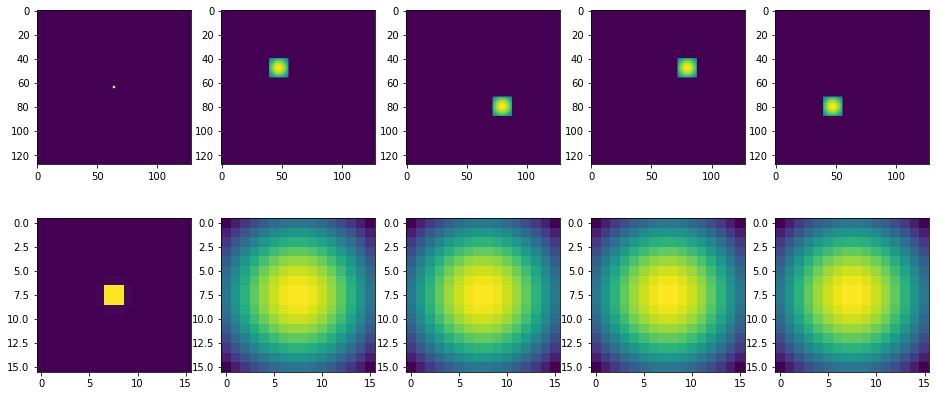

In [57]:
index_from_coord = np.ravel_multi_index((64,64),astro_shape)
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(16,7))
centre = np.array([64,64])
for i,index in enumerate([centre*[1,1],centre*[0.75,0.75],centre*[1.25,1.25],centre*[0.75,1.25],centre*[1.25,0.75]]):
    index_from_coord = round(np.ravel_multi_index(index.astype(np.int),astro_shape))
    ax[0,i].imshow(np.reshape(y_ground_truth[index_from_coord],astro_shape))
    ax[1,i].imshow(np.reshape(y_ground_truth_2d[index_from_coord],psf_window_shape))

## Model building

###  Multilayer perceptron | (x,y) in PSF out | Fails to converge

In [ ]:
def keras_model_fc():
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

###  Multilayer perceptron using convs (found in a paper) | (x,y) in PSF out | Fails to converge,

In [60]:
def keras_model_cov():
    model = Sequential()
    model.add(InputLayer(input_shape=x_indices_clean_scaled.shape))
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
    model.add(UpSampling1D(size=2))
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
    # model.add(UpSampling1D(size=2))
    # model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
    # model.add(UpSampling1D(size=2))
    # model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
    model.add(UpSampling1D(size=2))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

### Larger version | (x,y) in PSF out | Converges but cheats by making all the PSFs the same

In [66]:
if(BUILD_MODEL):
    def keras_model_cov1d():
        model = keras.models.Sequential()
        layer_shape = 2
        model.add(Dense(2, input_dim=layer_shape))
        model.add(LeakyReLU(alpha=0.05))
        # model.add(Reshape((layer_shape, 1, 1)))
        # model.add(Flatten())
        for i in np.arange(0, 12):
            model.add(Reshape((layer_shape, 1, 1)))
            model.add(UpSampling2D(size=(2, 1)))
            model.add(Reshape((layer_shape * 2, 1)))
            model.add(Conv1D(filters=1, kernel_size=2, activation='relu'))
            model.add(Flatten())
            # model.add(Dropout(0.5))

            layer_shape = layer_shape * 2 - 1
        model.add(Dense(128))
        model.add(Dropout(0.2))
        model.add(Dense(128 * 128))
        model.add(LeakyReLU(alpha=0.05))
        model.add(Dropout(0.2))
        # model.add(Flatten())
        # model.add(Dropout(0.5))
        # model.add(Dense(100, activation='relu'))
        model.compile(loss='mean_squared_error',
                      optimizer='adam',
                      metrics=[metrics.mae, metrics.accuracy])
        # loss = keras.optimizers.Adadelta()
        # model.compile(loss='mean_squared_error',
        #               optimizer=loss,
        #               metrics=['accuracy'])
        model.compile(loss='logcosh',
                      optimizer='sgd',
                      metrics=['accuracy'])
        model.build()
        return model

###  2D conv net 
Image with a pixel on, at the respective coordinate in the out PSF

Converges but cheats by making all the PSFs the same

In [68]:
if(BUILD_MODEL):
    def keras_model_cov2d(layer_shape=2, output_size=128):
        iterations = np.log2(output_size) - 1
        model = keras.models.Sequential()
        model.add(Dense(128, input_dim=layer_shape))
        model.add(LeakyReLU(alpha=0.05))
        model.add(Dense(2))
        # model.add(Conv2D(filters=2, kernel_size=2, activation='relu'))
        model.add(Reshape((layer_shape, 1, 1)))
        model.add(UpSampling2D(size=(1, 2)))
        for i in np.arange(0, iterations):
            model.add(UpSampling2D(size=(4, 4)))
            # model.add(Conv2D(filters=2, kernel_size=2, activation='relu'))
            model.add(Conv2D(32, 3, activation='relu',
                             padding='same', kernel_initializer='he_normal'))
            model.add(LeakyReLU(alpha=0.05))
            model.add(Conv2D(32, 3, activation='relu',
                          padding='same', kernel_initializer='he_normal'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.5))
        # model.add(MaxPooling2D(pool_size=(128/9, 128/9)))
        model.add(Conv2D(32, 3, activation='relu',
                         padding='same', kernel_initializer='he_normal'))
        model.add(Conv2D(2, 3, activation='relu', padding='same',
                         kernel_initializer='he_normal'))
        model.add(Conv2D(1, 1, activation='sigmoid'))
        model.add(Reshape((output_size, output_size)))
        model.summary()
        model.compile(loss='mean_squared_error',
                      optimizer='adam',
                      metrics=[metrics.mae, metrics.accuracy])
        model.build()
        return model

In [ ]:
classifiers = [
    # svm.SVR(),
    # neural_network.MLPRegressor(hidden_layer_sizes=(64,64),
    #                             verbose=True),
    # neighbors.KNeighborsRegressor(),
    KerasRegressor(build_fn=keras_model_cov, epochs=100,
                   nb_epoch=100, batch_size=64, verbose=1),
    KerasRegressor(build_fn=keras_model_fc, epochs=100,
                   nb_epoch=100, batch_size=64, verbose=1)
    # svm.SVR(),
    # gaussian_process.GaussianProcessRegressor(),
    # linear_model.SGDRegressor(),
    # linear_model.BayesianRidge(),
    # linear_model.LassoLars(),
    # linear_model.ARDRegression(),
    # linear_model.PassiveAggressiveRegressor(),
    # linear_model.TheilSenRegressor(),
    # linear_model.LinearRegression()
]

# Need to invert scaling

batch_size = 1

In [ ]:
# (*x_indices_scaled.shape,1)
# histor = the_model.fit(x_indices_clean_scaled, y_values_clean_2d_scaled)
# x_indices_scaled.shape

# samples = x_indices_scaled.shape[0]
# feature_size = 3

# x = np.expand_dims(x_indices_scaled, -1)

# BUILD_MODEL = 1
layer_shape = 2
output_size =128

In [ ]:
# if(BUILD_MODEL):
model = keras_model_cov1d()
model = keras_model_cov2d(output_size=16)
epochs = 10
seed = 7
# scikit_model = KerasClassifier(build_fn=model, epochs=epochs, batch_size=batch_size)
# x_indices_clean_scaled.shape
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# results = cross_validate(scikit_model, x_indices_clean_scaled, y_values_2d_clean, cv=kfold)

# model.summary()
# plt.imshow(y_values_2d_clean_scaled[0])

# model.fit(x_indices_clean, y_values_2d_clean_scaled,
#           # validation_data=(x_test, y_ground_truth_2d_scaled),
#           batch_size=batch_size,
#           epochs=epochs)
#
# model.save('keras_model_cov2d_flat_2.h5')

# y_predictions = model.predict(x_test)
# score = model.evaluate(x=x_test, y=y_ground_truth_2d_scaled, verbose=1)

# plt.imshow(np.sum(y_values_2d_clean, axis=0))
# plt.imshow(np.sum(y_ground_truth_2d_scaled[nuked_finite_rows], axis=0))
# plt.imshow(np.sum(y_predictions[nuked_finite_rows], axis=0))
#
#
# plt.imshow(y_predictions[64 * 64])

<p float="center">
    <img src="care_model.png" width="500"/>
</p>


### CARE MODEL
U-net conv net for "image restoration", converges but produces a static PSF

In [70]:
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, IsotropicCARE,CARE
from csbdeep.utils import download_and_extract_zip_file, axes_dict, plot_some, plot_history

from PIL import Image

Create array of images with a spot at respective coordinate

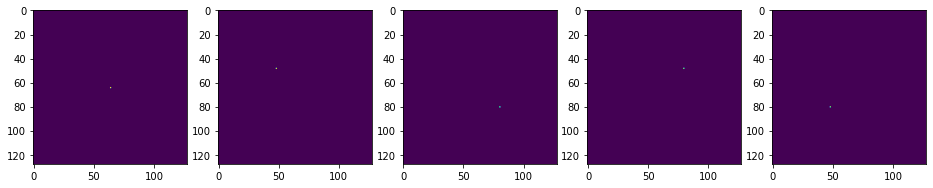

In [86]:
delta_array = np.zeros((coords.shape[0],128,128))

for i in np.arange(0,coords.shape[0]):
    delta_array[i,coords[i,0],coords[i,1]] = 1

index_from_coord = np.ravel_multi_index((64,64),astro_shape)
fig,ax = plt.subplots(ncols=5,nrows=1,figsize=(16,7))
centre = np.array([64,64])
for i,index in enumerate([centre*[1,1],centre*[0.75,0.75],centre*[1.25,1.25],centre*[0.75,1.25],centre*[1.25,0.75]]):
    index_from_coord = round(np.ravel_multi_index(index.astype(np.int),astro_shape))
#     ax[0,i].imshow(np.reshape(y_ground_truth[index_from_coord],astro_shape))
#     ax[1,i].imshow(np.reshape(y_ground_truth_2d[index_from_coord],psf_window_shape))    
    ax[i].imshow(delta_array[index_from_coord])

Remove PSFs randomly:

In [79]:
## Find threshold of where model fsails to converge
delta_array_nuked = delta_array[nuked_finite_rows]

Massage arrays for CARE to be able to read (1 extra dimension for colour that we don't use):

In [82]:
X = np.expand_dims(delta_array_nuked, -1);X.shape
Y = np.expand_dims(y_values_2d_clean_128,-1);Y.shape
X_val = np.expand_dims(delta_array,-1);X_val.shape
Y_val = np.expand_dims(y_ground_truth_2d_128,-1);Y_val.shape

(16384, 128, 128, 1)

In [ ]:
# plt.imshow(y_ground_truth_2d_128[int((128*128)/2 + 128/2)])

# im = Image.fromarray(y_values_2d_clean_128[600]).convert("RGB")
# im.show()
# plt.imshow(y_values_2d_clean[500])


# download_and_extract_zip_file (
#     url       = 'http://csbdeep.bioimagecomputing.com/example_data/synthetic_disks.zip',
#     targetdir = 'data',
# )
# (_,_), (_,_), axes = load_training_data('data/synthetic_disks/data.npz', validation_split=0.1, verbose=True)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

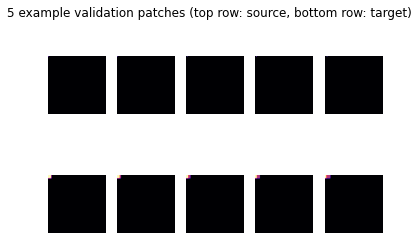

In [83]:
axes = 'SYXC'
c = axes_dict(axes)['C'];c
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

# plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');
config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(config)
vars(config)

In [ ]:
# axes ='XY'
# config = Config(axes, 1, 1, train_steps_per_epoch=30)

In [84]:
model = CARE(config, 'my_model', basedir='models')
history = model.train(X,Y, validation_data=(X_val,Y_val))

/homes/ctr26/miniconda3/envs/py37/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /homes/ctr26/gdrive/+projects/2019_jrl/2019_jRL_impute/models/my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 6/30 [=====>........................] - ETA: 11:25 - loss: 0.3460 - mse: 0.0126 - mae: 0.0139

KeyboardInterrupt: 

# Conclusions

- Matrix RL algorithm is functional and can work with spatially varying point spread functions
- Need to generate a method for harvest H from experimental data, i.e. impute $\mathbf{H}'s missing rows
- Matrix imputation is not designed for filling in entire rows
- Simple machine learning algorithms fail to converge
- Conv nets converge but cheat
- Training data here may be faulty anyway so need to regenerate that correctly

## Addendum

You can also consider the case of using multiple $\mathbf{f}_n$ images and respective $\mathbf{H_n}$ measurement matrices.

By concantenating H to be a vector of $\mathbf{H}_n$s you'll see that the LHS requires multiple $\mathbf{f}_n$s in but for still a single $\mathbf{g}$ structure:

\begin{align*}
\left(\begin{array}{c}
\left[\mathbf{f}_{1}\right] \\ \left[\mathbf{f}_{2}\right] \\
\end{array}\right) &=\left(\begin{array}{cc}
\left[\mathbf{H}_{1}\right] & \left[\mathbf{H}_{2}\right]
\end{array}\right) \mathbf{g}
\end{align*}

this means we can infant **fuse** images of complimentary strengths (as in *SIM* and *Lightfield*).

In [ ]:
# history = model.train(X,Y, validation_data=(X_val,Y_val))



    #
# coords = np.unravel_index(i, astro.shape)
#
# # plt.imshow()
# y_predict = model.predict(x)
# for i in np.arange(N_v):
#     y_predict_current = y_predict[i, :].reshape((10, 10))
#     plt.imsave(
#         f'./output/predict_psf/{str(i).zfill(6)}.png', y_predict_current)
# # plt.imsave(,)
#
# # np.nansum(np.sqrt(y_predict**2-y**2))
#
# # plt.imshow(a.reshape((10,10)))
#
# plt.imshow(measurement_matrix_3d[:, :, ].reshape((10, 10)))
# samples = measurement_matrix_3d_nuked.shape[2]
#
# model = keras_model_fc()
# # for classifier in classifiers:
# # print(classifier)
# classifier = classifiers[1]
#
# name = classifier.__module__
# print(f'{name}')
# classifier.fit(x_indices_clean_scaled, y_values_clean_scaled)
# y_values_predict_scaled = classifier.predict(x_indices_scaled)
#
# score = classifier.score(x_indices_scaled, y_ground_truth_scaled)
# mse = metrics.mean_squared_error(
#     y_ground_truth_scaled, y_values_predict_scaled)
# r2 = metrics.r2_score(y_ground_truth_scaled, y_values_predict_scaled)
# # classifier.score()
# correlation, p_value = pearsonr(
#     y_ground_truth_scaled.flatten(), y_values_predict_scaled.flatten())
# print(
#     f'Correlation: {correlation:.5f} | MSE:{mse:.5f} |  R2:{r2:.5f}  | Score:{score:.5f}')
# # plt.scatter(y_ground_truth_scaled,y_values_predict_scaled)
# # from sklearn.neural_network import MLPClassifier
# kfold = model_selection.KFold(n_splits=10)
# results = model_selection.cross_val_score(classifier,
#                                           x_indices_clean_scaled,
#                                           y_values_clean_scaled,
#                                           cv=kfold)
#
#
# estimators = []
# estimators.append(('standardize', preprocessing.StandardScaler()))
# estimators.append(('model', classifiers[1]))
# pipeline = pipeline.Pipeline(estimators)
#
# results = model_selection.cross_val_score(pipeline,
#                                           X_indices_clean,
#                                           y_values_clean,
#                                           cv=kfold)
#
# print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#
# # %% Begin RL matrix deconvolvution
# print("Build measurement matrix.")
# #
# # x0 = None
# # Rtol = 1e-6
# # NE_Rtol = 1e-6
# # max_iter = 100
# # sigmaSq = 0.0
# # beta = 0.0
#
# measurement_matrix_LO = scipy.sparse.linalg.aslinearoperator(
#     measurement_matrix)
# input_vector = astro_noisy_vector
#
# # Raw RL, no imputation
# FLAG_RAW = 0
# if(FLAG_RAW):
#     astro_rl_flat = richardson_lucy.matrix_reconstruction(
#         scipy.sparse.linalg.aslinearoperator(measurement_matrix),
#         input_vector, max_iter=30)
#     # astro_rl = astro
#     astro_rl = np.reshape(np.array(astro_rl_flat), astro_blur.shape)
#
#     fig, ax = plt.subplots(1, 3, figsize=[6.4 * 2, 4.8 * 2])
#
#     ax[0].imshow(astro)
#     ax[0].title.set_text("Raw")
#
#     ax[1].imshow(astro_noisy)
#     ax[1].title.set_text("Corrupted")
#
#     ax[2].imshow(astro_rl)
#     ax[2].title.set_text("Recovered")
#
#
# # %% Matrix nuking
#
# # H_df = pd.DataFrame(measurement_matrix)
#
#
#
#
# ######
# FLAG_IMPUTE = 0
# if(FLAG_IMPUTE):
#     from sklearn.linear_model import BayesianRidge
#     # %% Matrix impute
#
#     imp = IterativeImputer(missing_values=np.NaN,
#                            verbose=2, estimator=BayesianRidge())
#     imp.fit(measurement_matrix_3d_nuked)
#     H_fixed = imp.transform(measurement_matrix_3d_nuked)
#
#     error = measurement_matrix - H_fixed
#     sum_error = np.sum(np.sum(error))
#     sum_error
#     # plt.show()
#     plt.savefig("output/H_fixed.png")
#     plt.imshow(H_fixed)